In [1]:
import keras
from tensorflow import data as tf_data
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_MobileNet_v2
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import preprocess_input as preprocess_input_ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from pprint import pprint
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
import gc
gc.collect()

tensorflow.keras.backend.clear_session()

In [4]:
filepath = "/content/drive/MyDrive/archive.zip"
shutil.unpack_archive( filepath, "/content", 'zip')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image_dir = Path("/content/dataset")
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

print( image_df.head() )

image_df = image_df.sample(frac=1).reset_index(drop = True)

print( image_df.head() )

                                            Filepath  Label
0   /content/dataset/covid/covid-19-pneumonia-12.jpg  covid
1  /content/dataset/covid/1-s2.0-S168411822030060...  covid
2     /content/dataset/covid/kjr-21-e25-g001-l-a.jpg  covid
3  /content/dataset/covid/1-s2.0-S092966462030044...  covid
4  /content/dataset/covid/covid-19-pneumonia-15-P...  covid
                                            Filepath  Label
0     /content/dataset/covid/kjr-21-e24-g001-l-a.jpg  covid
1   /content/dataset/covid/covid-19-pneumonia-12.jpg  covid
2  /content/dataset/covid/1-s2.0-S092966462030044...  covid
3   /content/dataset/covid/all14238-fig-0001-m-b.jpg  covid
4  /content/dataset/covid/1-s2.0-S092966462030044...  covid


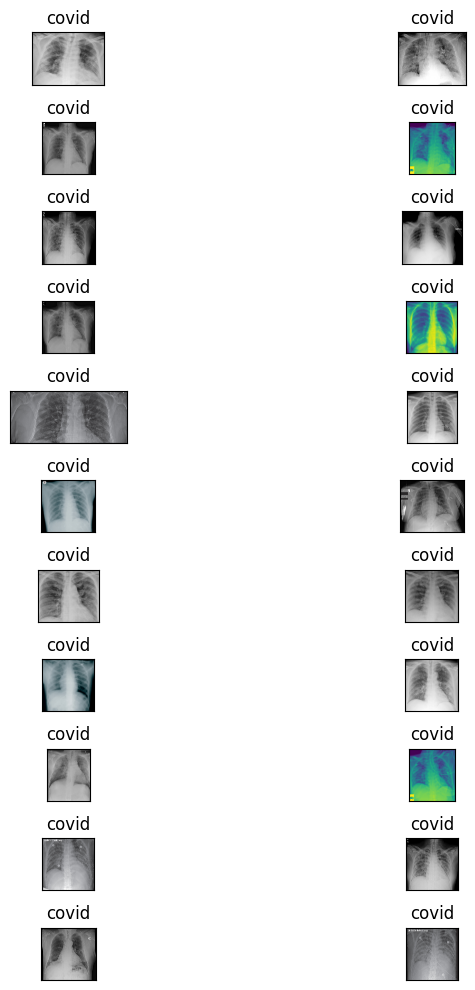

In [6]:
fig,axes=plt.subplots(nrows=11,ncols=2,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})


for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(image_df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [8]:
# Define ImageDataGenerator for training data with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_MobileNet_v2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

# Define ImageDataGenerator for validation and testing data without augmentation
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input_MobileNet_v2)




# Create generators for training, validation, and testing data
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,

)

Found 14 validated image filenames belonging to 1 classes.
Found 3 validated image filenames belonging to 1 classes.
Found 3 validated image filenames belonging to 1 classes.


In [9]:
# Model
inputshape=(224, 224, 3)

inputs = layers.Input(inputshape)
base_model = MobileNetV2( input_shape=inputshape, include_top=False )

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(30, activation='relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(2, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 30)                38430     
                                                                

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint('/content/model.h5', save_best_only=True, save_weights_only=False)
learningrateregulizer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-5)


model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit(train_images, epochs=50,
                    validation_data=val_images,
                     callbacks=[earlystopping, checkpoint, learningrateregulizer],
                    batch_size=128)

Epoch 1/50
1/1 [==============================] - 26s 26s/step - loss: 1.7583 - accuracy: 0.3571 - val_loss: 3.7067 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 3.0415 - accuracy: 0.0714 - val_loss: 5.1448 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 2.4283 - accuracy: 0.7143 - val_loss: 4.1948 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 2.1448 - accuracy: 0.3571 - val_loss: 3.8328 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 2.8912 - accuracy: 0.2857 - val_loss: 3.4017 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 2.8811 - accuracy: 0.1429 - val_loss: 2.9554 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 3.341

In [15]:
results_train = model.evaluate(train_images, verbose=0)

print("Train Loss: {:.5f}".format(results_train[0]))
print("Train Accuracy: {:.2f}%".format(results_train[1] * 100))

Train Loss: 2.86126
Train Accuracy: 14.29%


In [16]:
results_val = model.evaluate(val_images, verbose=0)

print("Val Loss: {:.5f}".format(results_val[0]))
print("Val Accuracy: {:.2f}%".format(results_val[1] * 100))

Val Loss: 2.87673
Val Accuracy: 0.00%


In [17]:
results_test = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

Test Loss: 3.33681
Test Accuracy: 0.00%


1/1 [==============================] - 0s 414ms/step
The first 5 predictions: ['covid', 'covid', 'Unknown']


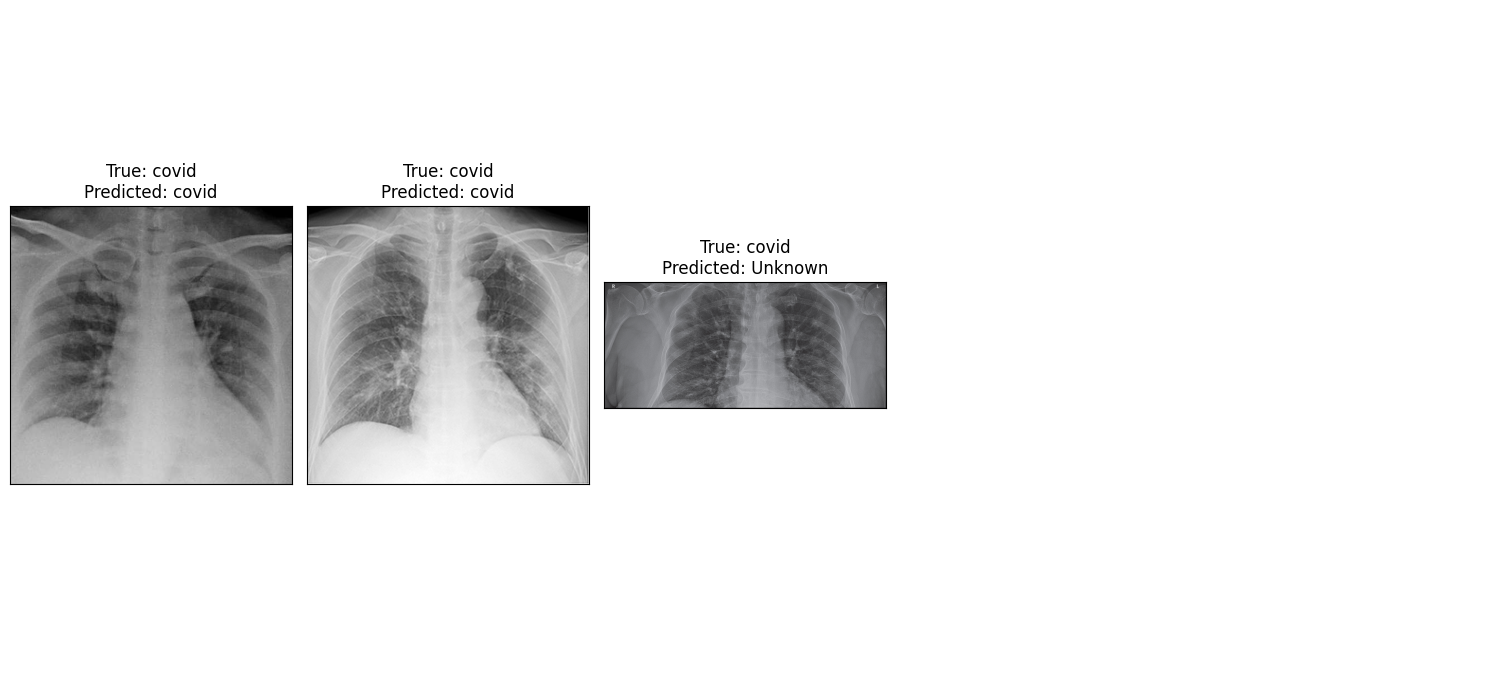

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
# Invert the dictionary to map predicted indices to labels
labels = dict((v,k) for k,v in labels.items())

# Ensure predicted labels are within the available keys, providing a default if not
pred = [labels.get(k, 'Unknown') for k in pred]  # Use 'Unknown' for missing keys

# Display the result
print(f'The first 5 predictions: {pred[:10]}')

# Display 15 picture of the dataset with their labels
# Adjust the number of plots to match the length of 'pred'
num_plots = len(pred)
num_cols = 5  # You can adjust this
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_plots:
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
    else:
        ax.axis('off')  # Hide unused plots

plt.tight_layout()
plt.show()